In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
import os
import time
import pandas as pd
import numpy as np
import argparse
from tqdm import tqdm
from torch.utils.data import DataLoader
matplotlib.style.use('ggplot')
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader

In [8]:
df = pd.read_csv("./dataset/0.1percent_2classes.csv")
df.head(10)

,flow_duration,header_length,protocol_type,duration,rate,srate,drate,fin_flag_number,syn_flag_number,rst_flag_number,...,std,tot_size,iat,number,radius,covariance,variance,weight,magnitude,benign
0,0.000000,54,TCP,64.00,48,48,0.0,True,False,True,...,0.000000,54.00,83345000.0,9.5,0.000000,0.000000,0.00,141.55,10.392304,False
1,0.000000,55,TCP,65.91,29,29,0.0,False,True,False,...,1.072485,55.60,82985560.0,9.5,1.528833,38.961185,0.03,141.55,10.416152,False
2,0.035177,17230,UDP,64.00,24362,24362,0.0,False,False,False,...,0.000000,50.00,83102410.0,9.5,0.000000,0.000000,0.00,141.55,10.000000,False
3,3.932406,389809,EGP,109.80,85,85,0.0,False,False,False,...,798.802860,672.00,166521020.0,13.5,1128.301500,636962.060000,1.00,244.60,48.637638,True
4,0.069597,11323,UDP,68.40,7890,7890,0.0,False,False,False,...,11.195639,54.62,83487416.0,9.5,15.865254,763.990700,0.26,141.55,10.310076,False
5,0.000000,54,TCP,64.00,15,15,0.0,False,True,False,...,0.000000,54.00,83093270.0,9.5,0.000000,0.000000,0.00,141.55,10.392304,False
6,0.000000,0,ICMP,64.00,16,16,0.0,False,False,False,...,0.000000,42.00,83128640.0,9.5,0.000000,0.000000,0.00,141.55,9.165152,False
7,1.084294,114,TCP,64.00,2,2,0.0,False,True,False,...,0.000000,54.00,83361180.0,9.5,0.000000,0.000000,0.00,141.55,10.392304,False
8,0.025817,22811,CHAOS,67.59,17867,17867,0.0,False,False,False,...,1.352091,50.81,83012136.0,9.5,1.918276,18.256811,0.21,141.55,10.035435,False
9,0.004396,6,RSVP,64.00,12,12,0.0,False,False,False,...,9.240546,587.19,83694056.0,9.5,13.104511,1077.457200,0.08,141.55,34.338886,False


In [10]:
def get_feats(categorical : bool=False, important : bool=False) -> list:
    '''
    Returns X and y Tensors, optionally selecting categorical feature 
    (protocol_type) or important features only (from prior analysis)
    '''
    
    # Same no matter which features selected
    # y = torch.from_numpy( df['benign'].astype('float32').to_numpy() )
    y = 0
    
    # Features based on importance analysis (https://www.kaggle.com/code/madhavmalhotra/genetic-algorithm-feature-selection)
    if important:
        X = df.loc[:, ["duration", "srate", "drate", "syn_flag_number", "psh_flag_number", "ack_flag_number", "ack_count", "syn_count", "rst_count", "header_length", "https", "ssh", "flow_duration", "avg", "max", "tot_sum", "min", "iat", "magnitude", "radius", "variance"]]
        scaler = StandardScaler()
        X = scaler.fit_transform(X) 
        X = torch.from_numpy( X.astype('float32') )
    
    # All features, including categorical to dummy
    elif categorical:
        X = pd.get_dummies(df['protocol_type'])
        df2 = pd.concat([df.drop(['protocol_type', 'benign'], axis=1), X], axis=1).astype('float32').to_numpy()
        scaler = StandardScaler()
        df2 = scaler.fit_transform(df2)
        X = torch.from_numpy(df2)

    # All numerical features
    else:
        X = df.drop(['protocol_type', 'benign'], axis=1)
        X = torch.from_numpy( X.astype('float32').to_numpy() )

    return X,y

In [11]:

X, _ = get_feats(categorical=False, important=True)
n_data, n_dims = X.shape

batch_size = 2048
data = TensorDataset(X)
data_tr, data_te = torch.utils.data.random_split(data, [0.8, 0.2])

load_tr = DataLoader(data_tr, batch_size=batch_size, shuffle=True)
load_te = DataLoader(data_te, batch_size=batch_size, shuffle=True)

# Print the shape of the feature tensor X
print(X.shape)
print(X[:5,:5])

torch.Size([4668653, 21])
tensor([[-1.6773e-01, -9.0561e-02, -1.1721e-03, -5.1147e-01, -3.1013e-01],
        [-3.1224e-02, -9.0753e-02, -1.1721e-03,  1.9551e+00, -3.1013e-01],
        [-1.6773e-01,  1.5548e-01, -1.1721e-03, -5.1147e-01, -3.1013e-01],
        [ 3.1056e+00, -9.0187e-02, -1.1721e-03, -5.1147e-01, -3.1013e-01],
        [ 1.4674e-01, -1.1204e-02, -1.1721e-03, -5.1147e-01, -3.1013e-01]])


In [12]:
# Define the SparseAutoencoder class
class SparseAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_states, l1_weight=0.01):
        super(SparseAutoencoder, self).__init__()

        # Encoder layer (input_size to hidden_size)
        self.encoder = nn.Sequential (
            nn.Linear(input_size, hidden_states[0]),
            nn.LeakyReLU(0.1),
            nn.Linear(hidden_states[0], hidden_states[1]),
            nn.LeakyReLU(0.1),
            nn.Linear(hidden_states[1], hidden_states[2]),
            nn.LeakyReLU(0.1),
        )

        # Decoder layer (hidden_size to output_size)
        self.decoder = nn.Sequential (
            nn.Linear(hidden_states[2], hidden_states[1]),
            nn.LeakyReLU(0.1),
            nn.Linear(hidden_states[1], hidden_states[0]),
            nn.LeakyReLU(0.1),
            nn.Linear(hidden_states[0], input_size),
            nn.LeakyReLU(0.1),
        )

        # L1 regularization weight
        self.l1_weight = l1_weight

    def forward(self, input_data):
        '''
        Defining the forward pass
        '''
        self.hidden = self.encoder(input_data)
        self.decoded = self.decoder(self.hidden)

        return self.decoded, self.hidden

    def l1_regularization_activation(self):
        '''
        Deine the L1 regularization on the activations
        '''
        return self.l1_weight * torch.norm(self.hidden, p=1)
    
    def l1_regularization_loss(self, input_data, output_data):
        '''
        Define the L1 regularization loss
        '''
        return F.mse_loss(input_data, output_data) + self.l1_regularization_activation()

Using device: mps
Epoch [0/50]  Reconstruction Loss: 0.5419  L1 Regularization: 0.0679
Epoch [1/50]  Reconstruction Loss: 0.5060  L1 Regularization: 0.0459
Epoch [2/50]  Reconstruction Loss: 0.6412  L1 Regularization: 0.0364
Epoch [3/50]  Reconstruction Loss: 0.4211  L1 Regularization: 0.0496
Epoch [4/50]  Reconstruction Loss: 0.4750  L1 Regularization: 0.0255
Epoch [5/50]  Reconstruction Loss: 0.5093  L1 Regularization: 0.0215
Epoch [6/50]  Reconstruction Loss: 0.6314  L1 Regularization: 0.0555
Epoch [7/50]  Reconstruction Loss: 0.3369  L1 Regularization: 0.0322
Epoch [8/50]  Reconstruction Loss: 0.3853  L1 Regularization: 0.0301
Epoch [9/50]  Reconstruction Loss: 0.3899  L1 Regularization: 0.0382
Epoch [10/50]  Reconstruction Loss: 0.4287  L1 Regularization: 0.0559
Epoch [11/50]  Reconstruction Loss: 0.3898  L1 Regularization: 0.0348
Epoch [12/50]  Reconstruction Loss: 0.3139  L1 Regularization: 0.0369
Epoch [13/50]  Reconstruction Loss: 0.3272  L1 Regularization: 0.0327
Epoch [14/50

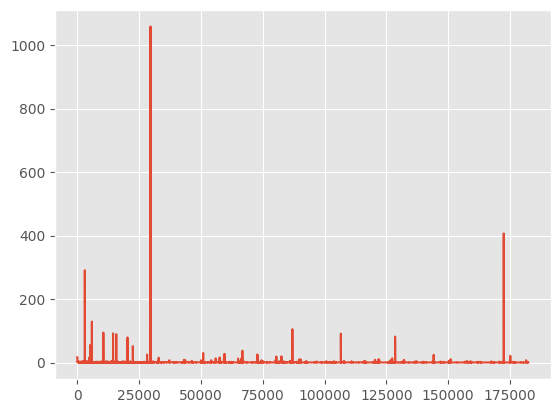

In [ ]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f'Using device: {device}')

input_size = 21
hidden_size = 10
hidden_states = [64, 32, 16, 10]
l1_weight = 0.01
autoencoder = SparseAutoencoder(input_size, hidden_states, l1_weight=l1_weight).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
num_epochs = 50
loss_history = []

for epoch in range(num_epochs):
    
    for batch in load_tr:
        inputs = batch[0].to(device)
        reconstruction, hidden = autoencoder(inputs)
        total_loss = autoencoder.l1_regularization_loss(inputs, reconstruction)
        
        optimizer.zero_grad()  # Clear previous gradients
        total_loss.backward()  # Compute gradients
        optimizer.step()       # Update parameters using optimizer
        
        loss_history.append(total_loss.item())
        
        reconstruction_loss = F.mse_loss(reconstruction, inputs)
        l1_reg = autoencoder.l1_regularization_activation()
        loss_history.append(total_loss.item())
    
    print(f'Epoch [{epoch}/{num_epochs}] ',
          f'Reconstruction Loss: {reconstruction_loss.item():.4f} ',
          f'L1 Regularization: {l1_reg.item():.4f}')
    
    
    
plt.plot(loss_history, label='Total Loss')

In [ ]:
# Print the final loss history
plt.plot(loss_history, label='Total Loss')

In [ ]:

def extract_compressed_data(model, data_loader):
    '''
    Extracting the compressed data from the model and data loader
    '''
    compressed_data = []
    for batch in data_loader:
        _, latent_representation = model(batch[0])
        compressed_data.append(latent_representation)
    
    compressed_data = torch.cat(compressed_data)
    return compressed_data


    